# GNN project - node classifiaction

## EDA

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

In [2]:
NODES  = pd.read_csv('data/SS-Butterfly_labels.tsv', sep='\t')
EDGES  = pd.read_csv('data/SS-Butterfly_weights.tsv', sep='\t')

In [3]:
NODES = NODES.rename(columns={'# Node_ID': 'Node_ID', 'Species': 'species'})
print(NODES.shape)
NODES.head()

(832, 2)


,Node_ID,species
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [4]:
EDGES = EDGES.rename(columns={'# NodeID1': 'NodeID1', 'NodeID2': 'NodeID2', 'Image similarity weight': 'Image similarity weight'})
EDGES.head()

,NodeID1,NodeID2,Image similarity weight
0,0,4,0.029663
1,0,5,0.250146
2,0,7,0.052237
3,0,10,0.096204
4,0,12,0.102050


In [5]:
G = nx.from_pandas_edgelist(EDGES, 'NodeID1', 'NodeID2')

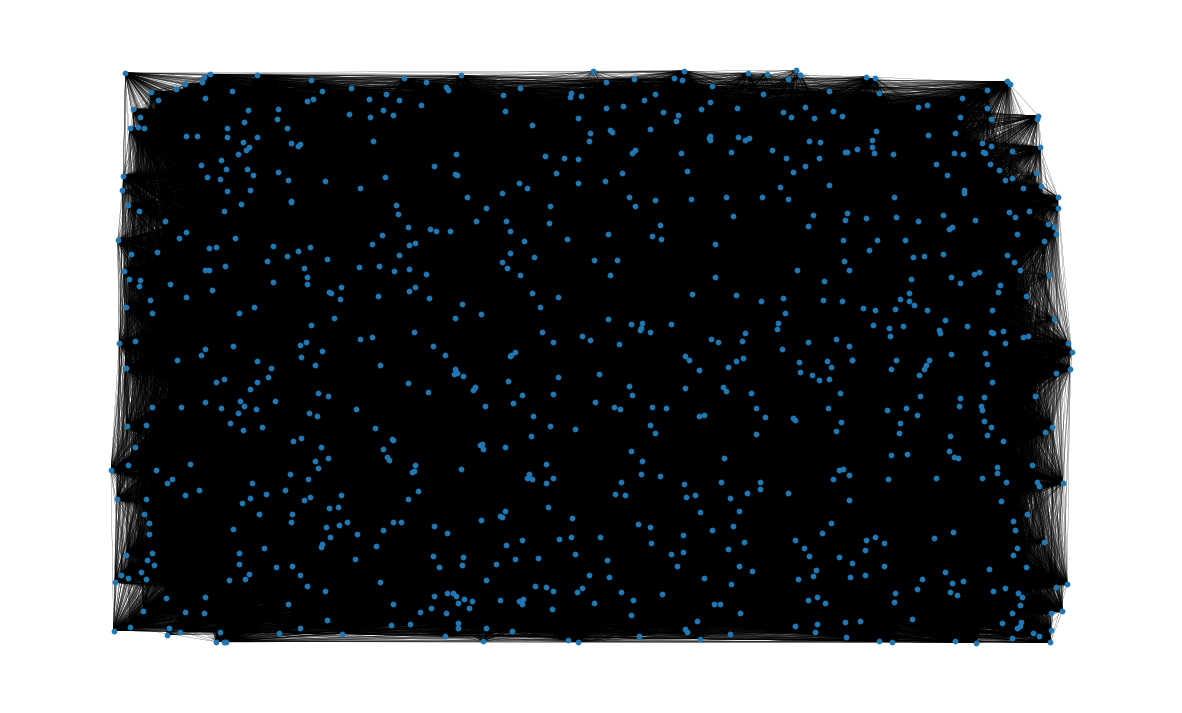

In [6]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

In [7]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Mean degree of nodes:", np.mean([d for _, d in G.degree()]))


Number of nodes: 832
Number of edges: 86528
Mean degree of nodes: 208.0


In [8]:
print("Target classes:", NODES["species"].unique())

Target classes: [ 1  2  3  4  5  6  7  8  9 10]


## GNN model for node classifiaction

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

# Create a custom GNN model
class GNNNodeClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [10]:
# Prepare the data
nodes = NODES['Node_ID'].values
labels = NODES['species'].values
edges = EDGES[['NodeID1', 'NodeID2']].values.transpose()
weights = EDGES['Image similarity weight'].values

x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)  # Node features
y = torch.tensor(labels, dtype=torch.long)  # Node labels
edge_index = torch.tensor(edges, dtype=torch.long)  # Edge indices
edge_weight = torch.tensor(weights, dtype=torch.float)  # Edge weights

data = Data(x=x, edge_index=edge_index, y=y, edge_weight=edge_weight)


In [11]:
# Define model parameters
num_features = 1  # Number of node features (in this case, just 'Node_ID')
num_classes = torch.unique(y).size(0)  # Number of unique classes

# Create the GNN model
model = GNNNodeClassifier(num_features, num_classes)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train the model
model.train()


GNNNodeClassifier(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 10)
)

In [12]:
losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data)

    train_indices = [_ for _ in range(832)]  # Indices of nodes in the training set
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_indices] = True
    data.train_mask = train_mask

    predictions = out
    targets = data.y - 1

    loss = criterion(predictions[data.train_mask], targets[data.train_mask])
    loss.backward()
    optimizer.step()

    losses += [loss.item()]
    if epoch%100==1:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Epoch: 2, Loss: 130.33847045898438
Epoch: 102, Loss: 2.0133519172668457
Epoch: 202, Loss: 1.867724895477295
Epoch: 302, Loss: 1.7588276863098145
Epoch: 402, Loss: 1.6750284433364868
Epoch: 502, Loss: 1.606444239616394
Epoch: 602, Loss: 1.5474523305892944
Epoch: 702, Loss: 1.4949684143066406
Epoch: 802, Loss: 1.4475834369659424
Epoch: 902, Loss: 1.404740571975708


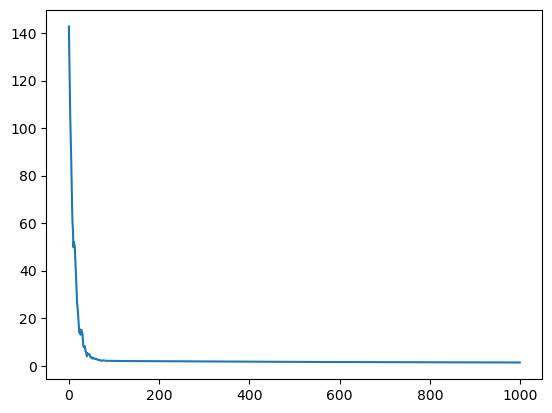

In [13]:
plt.plot(losses)
plt.show()

In [ ]:
# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     pred = model(data).argmax(dim=1)
#     correct = pred[data.test_mask] == data.y[data.test_mask]
#     accuracy = int(correct.sum()) / int(data.test_mask.sum())
#     print(f"Accuracy: {accuracy}")


## OLD CODE

In [1]:
import pandas as pd

labels_df  = pd.read_csv('data/SS-Butterfly_labels.tsv', sep='\t')
weights_df  = pd.read_csv('data/SS-Butterfly_weights.tsv', sep='\t')

In [2]:
labels_df  = labels_df .rename(columns={'# Node_ID': 'Node_ID', 'Species': 'species'})
labels_df .head()

,Node_ID,species
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [3]:
weights_df  = weights_df .rename(columns={'# NodeID1': 'NodeID1', 'NodeID2': 'NodeID2', 'Image similarity weight': 'Image similarity weight'})
weights_df .head()


,NodeID1,NodeID2,Image similarity weight
0,0,4,0.029663
1,0,5,0.250146
2,0,7,0.052237
3,0,10,0.096204
4,0,12,0.102050


In [7]:
# # If you have installed dgl-cuXX package, please uninstall it first.
# !pip install  dgl -f https://data.dgl.ai/wheels/repo.html
# !pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [6]:
import dgl

# Create a DGL graph from the weights DataFrame
graph = dgl.graph((weights_df["NodeID1"], weights_df["NodeID2"]))

In [8]:
import torch

# Add the species labels as node features to the graph
species = torch.tensor(labels_df['species'].values)
graph.ndata['species'] = species

In [9]:
import torch.nn as nn

# Define the model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [10]:
labels_df['species'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [12]:
# Set the model parameters
in_feats = 3 # number of input features per node (i.e., the number of dimensions in your node features tensor)
hidden_size = 16
num_classes = len(labels_df['species'].unique()) # number of unique species labels in the dataset


In [13]:
# Create the model
model = GCN(in_feats, hidden_size, num_classes)

In [14]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

In [15]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
import networkx as nx

G = nx.Graph()

# add nodes to the graph
                                    # Node_ID	species
for node_id, species in labels_df[['Node_ID', 'species']].values:
    G.add_node(node_id, species=species)

# add edges to the graph
                                        # NodeID1	NodeID2	    Image similarity weight
for node1, node2, weight in weights_df[['NodeID1', 'NodeID2', 'Image similarity weight']].values:
    G.add_edge(node1, node2, weight=weight)


In [18]:
import dgl
import torch

dgl_G = dgl.from_networkx(G)
feature_tensor = torch.rand((dgl_G.number_of_nodes(), 10))
dgl_G.ndata['species'] = feature_tensor

In [ ]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    logits = model(graph, feature_tensor.float())
    loss = loss_fn(logits[train_mask], label_tensor[train_mask])

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_logits = model(graph, feature_tensor.float())
        val_loss = loss_fn(val_logits[val_mask], label_tensor[val_mask])
        val_acc = (val_logits[val_mask].argmax(dim=1) == label_tensor[val_mask]).float().mean()

    print(f"Epoch {epoch+1}: train_loss={loss.item():.4f} val_loss={val_loss.item():.4f} val_acc={val_acc.item():.4f}")


In [4]:
import networkx as nx

G = nx.Graph()

# add nodes to the graph
for node_id, species in node_df[['Node_ID', 'species']].values:
    G.add_node(node_id, species=species)

# add edges to the graph
for node1, node2, weight in edge_df[['NodeID1', 'NodeID2', 'Image similarity weight']].values:
    G.add_edge(node1, node2, weight=weight)


In [29]:
print(G)

Graph with 832 nodes and 86528 edges


In [19]:
# # If you have installed dgl-cuXX package, please uninstall it first.
# !pip install  dgl -f https://data.dgl.ai/wheels/repo.html
# !pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [32]:
import dgl
import torch

dgl_G = dgl.from_networkx(G)
feature_tensor = torch.rand((dgl_G.number_of_nodes(), 10))
dgl_G.ndata['species'] = feature_tensor

In [33]:
import torch.nn as nn
import dgl.nn as dglnn

class GNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats)
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats)
        
    def forward(self, graph):
        x = graph.ndata['species']
        x = self.conv1(graph, x)
        x = nn.functional.relu(x)
        x = self.conv2(graph, x)
        graph.ndata['h'] = x
        hg = dgl.mean_nodes(graph, 'h')
        return hg


In [34]:
import torch.optim as optim

model = GNN(in_feats=1, hidden_feats=16, out_feats=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 1

for epoch in range(num_epochs):
    # forward pass
    logits = model(dgl_G)
    loss = criterion(logits, dgl_G.ndata['species'])
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


RuntimeError: mat1 and mat2 shapes cannot be multiplied (832x10 and 1x16)

In [35]:
import matplotlib.pyplot as plt

# Convert the DGL graph to a NetworkX graph
nx_graph = dgl_G.to_networkx()

# Draw the graph using NetworkX
nx.draw(nx_graph, with_labels=True)

# Show the plot
plt.show()


KeyboardInterrupt: 